# Dados

In [3]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.animation as animation
import numpy as np
import math


In [4]:
breast=pd.read_csv('dados/breast.csv',header=None)
breast=breast.rename(columns={breast.columns[30]:'y'})
breast

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,y
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0.0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0.0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0.0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0.0


# Nomalizador

In [21]:
class Nomalizer:
    def __init__(self):
        self.y_max=0.0
        self.y_min=0.0
        self.x_max=[]
        self.x_min=[]

    def fit(self,x,y):
        # Pega os valores minimos de 
        self.y_max=y['y'].max().tolist()
        self.y_min=y['y'].min().tolist()

        # Pega os valores maximos e minimos do X
        self.x_max=x.max().tolist()
        self.x_min=x.min().tolist()
    
    def normalize(self,x,y):
        y_norm=y.map(self.y_norm_aux)
        x_norm=x.copy()
        norm_index=0
        for column in x.columns:
            x_column=[]
            for i in range(len(x[column])):
                x_column.append((x[column][i]-self.x_min[norm_index])/(self.x_max[norm_index]-self.x_min[norm_index]))
                
            norm_index+=1
            x_norm[column]=x_column    
        
        return x_norm,y_norm
    
    def desnormalize(self,x_norm,y_norm):
        y=y_norm.map(self.y_desnorm_aux)
        x=x_norm.copy()
        norm_index=0
        for column in x_norm.columns:
            x_column=[]
            for i in range(len(x_norm[column])):
                x_column.append((x_norm[column][i]*(self.x_max[norm_index]-self.x_min[norm_index]))+self.x_min[norm_index])
                
            norm_index+=1
            x[column]=x_column    
        
        return x,y
    
    def y_norm_aux(self,y):
        return (y-self.y_min)/(self.y_max-self.y_min)
    
    def y_desnorm_aux(self,y):
        return (y*(self.y_max-self.y_min))+self.y_min

# Modelos

In [28]:
class DiscirminanteGaussianoClassifier:
  def __init__(self,opt='SGD'):
    self.prob =[]
    self.matrizes_cov=[]
    self.medias=[]
    self.num_class=0
    

  def fit(self, x, y):
    y_column=y.columns.tolist()# Pega acoluna y
    x_columns=x.columns.tolist()# Pega as colunas x
    classes=list(set(y[y_column[0]]))# Pega as classes dos dados
    self.num_class=len(classes)# Guarda o numero de classes
    df_xy=pd.concat([x,y],axis=1)# Junta os dados temporariamente para separar as classes

    for categoria in classes:
      medias=[]
      df_class=df_xy[df_xy[y_column[0]]==categoria]# Pega as linhas do df que pertence a classe
      df_classXY=df_class.reset_index(drop=True)# Reinicia o index
      df_classX=df_classXY.drop(columns=df_classXY.columns[-1])# Retira a coluna y do df

      for column in x_columns:
        medias.append(df_classX[column].mean())# Pega as medias das colunas
        
      matriz_cov=np.cov(df_classX.values.T)# Produz a matriz de covariancia
      self.medias.append(medias)# Guarda as medias da classe
      self.matrizes_cov.append(matriz_cov)# Guarda a matriz de covariancia
   

  def predict(self, x):
    porc=1/self.num_class
    pred=[]
    for indice in range(len(x)):
      x_linha=x.iloc[indice].to_list()
      ys=[]
      for classe in range(self.num_class):
        det=np.linalg.det(self.matrizes_cov[classe])
        y=np.log(porc)-(np.log(det)/2)-(((np.array(x_linha)-np.array(self.medias[classe])).T @ np.linalg.pinv(self.matrizes_cov[classe]) @ (np.array(x_linha)-np.array(self.medias[classe])))/2)
        ys.append(y)
        
      if ys[0]==ys[1]:
        pred.append(1)
      elif ys[0]>ys[1]:
        pred.append(0)
      else:
        pred.append(1)

    return pred

In [27]:
class NaiveBayesGaussianoClassifier:
  def __init__(self,opt='SGD'):
    self.var_class=[]
    self.medias=[]
    self.num_class=0
    

  def fit(self, x, y):
    y_column=y.columns.tolist()# Pega acoluna y
    x_columns=x.columns.tolist()# Pega as colunas x
    classes=list(set(y[y_column[0]]))# Pega as classes dos dados
    self.num_class=len(classes)# Guarda o numero de classes
    df_xy=pd.concat([x,y],axis=1)# Junta os dados temporariamente para separar as classes

    for categoria in classes:
      medias=[]
      var_column=[]
      df_class=df_xy[df_xy[y_column[0]]==categoria]# Pega as linhas do df que pertence a classe
      df_classXY=df_class.reset_index(drop=True)# Reinicia o index
      df_classX=df_classXY.drop(columns=df_classXY.columns[-1])# Retira a coluna y do df

      for column in x_columns:
        media=df_classX[column].mean()
        column=df_classX[column].to_list()
        medias.append(media)# Pega as medias das colunas
        column_arr=np.array(column)
        var_sub=column_arr-media
        var_qua=var_sub**2
        var_sum=np.sum(var_qua)
        var_column.append(var_sum/(len(column)-1))
     
      self.medias.append(medias)# Guarda as medias da classe
      self.var_class.append(var_column)
   

  def predict(self, x):
    porc=1/self.num_class
    pred=[]
    for indice in range(len(x)):
      x_linha=x.iloc[indice].to_list()
      x_arr=np.array(x_linha)
      ys=[]

      for classe in range(self.num_class):
        log=[]
        sum2=[]
        media=self.medias[classe]
        vars=self.var_class[classe]

        for column in range(len(x_arr)):
          sub=x_arr[column]-media[column]
          qua=sub**2
          div=qua/vars[column]
          sum2.append(div)
          lg=2*np.pi*vars[column]
          log.append(np.log(lg))
          
        esum2=np.sum(sum2)
        esum1=np.sum(log)
        y=np.log(porc)-(esum1/2)-(esum2/2)
        ys.append(y) 
      if ys[0]==ys[1]:
        pred.append(1)
      elif ys[0]>ys[1]:
        pred.append(0)
      else:
        pred.append(1)

    return pred

In [29]:
class KNNClassifier:
  def __init__(self):
    self.df_train=pd.DataFrame()
    self.df=pd.DataFrame()
    

  def fit(self, x, y):
    df_xy=pd.concat([x,y],axis=1)# Junta os dados temporariamente para separar as classes
    self.df_train=x
    self.df=df_xy

   

  def predict(self,x,n):
    pred=[]
    for indice in range(len(x)):
      x_linha=x.iloc[indice].to_list()
      x_arr=np.array(x_linha)
      dist=[]
      df_dist=self.df.copy()
      for train_id in range(len(self.df_train)):
        x_t=self.df_train.iloc[train_id].to_list()
        x_t_arr=np.array(x_t)
        dist_sub=x_arr-x_t_arr
        dist_qua=dist_sub**2
        dist_sum=np.sum(dist_qua)
        dist_raiz=np.sqrt(dist_sum)
        dist.append(dist_raiz)
        
      df_dist['distancia']=dist
      df_min=df_dist.nsmallest(n,'distancia')
      df_0=df_min[df_min['y']==0.0]
      df_1=df_min[df_min['y']==1.0]
      
      if len(df_0)==len(df_1):
        pred.append(1)
      elif len(df_0)>len(df_1):
        pred.append(0)
      else:
        pred.append(1)
        
    return pred
    

# Experimento do modelo discriminante gaussiano

In [30]:
from sklearn.model_selection import KFold
import seaborn as sns

In [31]:
x=breast.iloc[:, 0:30]  
y=breast[['y']]

/////////////////////////////////////////////////
acuracia do modelo:  0.9473684210526315
revocação do modelo:  0.9436619718309859
precisao do modelo:  0.9710144927536232
f1-score do modelo:  0.9571428571428571


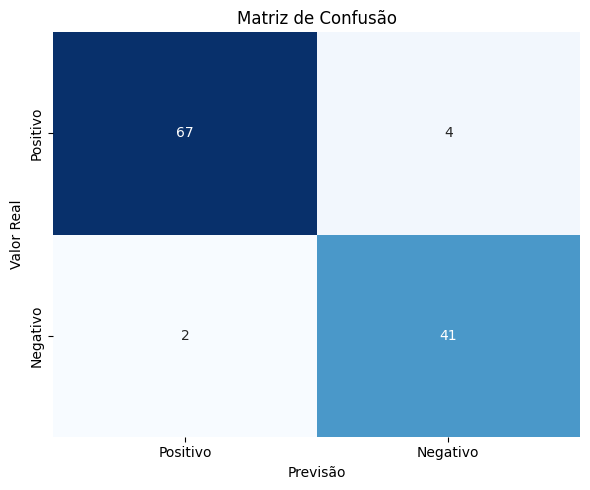

In [32]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Normalizando os dados
norm=Nomalizer()
norm.fit(X_train,y_train)
norm_Trx,norm_Try=norm.normalize(X_train,y_train)
norm_Tsx,norm_Tsy=norm.normalize(X_test,y_test)


# Treinando um modelo
model = DiscirminanteGaussianoClassifier()
model.fit(norm_Trx,y_train)

# Fazendo previsões
y_pred = model.predict(norm_Tsx)

# Contagem para de TP,FN,FP,TN para calcular metricas e matriz de confusão
TP = 0  # Verdadeiro Positivo
FN = 0  # Falso Negativo
FP = 0  # Falso Positivo
TN = 0  # Verdadeiro Negativo


indices = list(range(len(y_pred)))
for i in indices:
    if y_test['y'][i] == 1 and y_pred[i] == 1:
        TP += 1
    elif y_test['y'][i] == 0 and y_pred[i] == 0:
        TN += 1
    elif y_test['y'][i] == 0 and y_pred[i] == 1:
        FP += 1
    elif y_test['y'][i] == 1 and y_pred[i] == 0:
        FN += 1

matriz_confusao = np.array([[TP, FN],
                            [FP, TN]])
print("/////////////////////////////////////////////////")

# Calculo da acuracia
acuracia = (TP + TN) / len(norm_Tsy)
print("acuracia do modelo: ",acuracia)


# Calculo da revocação
revocacao = TP / (TP + FN)
print("revocação do modelo: ",revocacao)

# Calculando a precisão
precisao = TP / (TP + FP) 
print("precisao do modelo: ",precisao)

# Calculando f1-score
f1_score = 2 * (precisao * revocacao) / (precisao + revocacao)
print("f1-score do modelo: ",f1_score)

# Criar o gráfico
plt.figure(figsize=(6, 5))
ax = sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", cbar=False)

# Configurações do gráfico
ax.set_title("Matriz de Confusão")
ax.set_xlabel("Previsão")
ax.set_ylabel("Valor Real")

# Adicionando rótulos aos eixos
ax.xaxis.set_ticklabels(["Positivo", "Negativo"])
ax.yaxis.set_ticklabels(["Positivo", "Negativo"])

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [34]:
# Configurando o KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Para armazenar métricas de cada fold
mse_scores = []
acuracias =[]
revocacoes=[]
precisoes=[]
f1_scores=[]

# Loop pelos folds
for train_index, test_index in kf.split(x):
    # Dividindo os dados em treino e teste
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Normalizando os dados
    norm=Nomalizer()
    norm.fit(X_train,y_train)
    norm_Trx,norm_Try=norm.normalize(X_train,y_train)
    norm_Tsx,norm_Tsy=norm.normalize(X_test,y_test)


    # Treinando um modelo
    model = DiscirminanteGaussianoClassifier()
    model.fit(norm_Trx,y_train)

    # Fazendo previsões
    y_pred = model.predict(norm_Tsx)

    # Contagem para de TP,FN,FP,TN para calcular metricas e matriz de confusão
    TP = 0  # Verdadeiro Positivo
    FN = 0  # Falso Negativo
    FP = 0  # Falso Positivo
    TN = 0  # Verdadeiro Negativo

    indices = list(range(len(y_pred)))
    for i in indices:
        if y_test['y'][i] == 1 and y_pred[i] == 1:
            TP += 1
        elif y_test['y'][i] == 0 and y_pred[i] == 0:
            TN += 1
        elif y_test['y'][i] == 0 and y_pred[i] == 1:
            FP += 1
        elif y_test['y'][i] == 1 and y_pred[i] == 0:
            FN += 1

    matriz_confusao = np.array([[TP, FN],
                                [FP, TN]])
    print("/////////////////////////////////////////////////")

    # Calculo da acuracia
    acuracia = (TP + TN) / len(norm_Tsy)
    print("acuracia do modelo: ",acuracia)
    acuracias.append(acuracia)

    # Calculo da revocação
    revocacao = TP / (TP + FN)
    revocacoes.append(revocacao)
    print("revocação do modelo: ",revocacao)

    # Calculando a precisão
    precisao = TP / (TP + FP) 
    precisoes.append(precisao)
    print("precisao do modelo: ",precisao)

    # Calculando f1-score
    f1_score = 2 * (precisao * revocacao) / (precisao + revocacao)
    f1_scores.append(f1_score)
    print("f1-score do modelo: ",f1_score)


/////////////////////////////////////////////////
acuracia do modelo:  0.9473684210526315
revocação do modelo:  0.925
precisao do modelo:  1.0
f1-score do modelo:  0.961038961038961
/////////////////////////////////////////////////
acuracia do modelo:  0.9649122807017544
revocação do modelo:  1.0
precisao do modelo:  0.9393939393939394
f1-score do modelo:  0.96875
/////////////////////////////////////////////////
acuracia do modelo:  0.9824561403508771
revocação do modelo:  1.0
precisao do modelo:  0.9736842105263158
f1-score do modelo:  0.9866666666666666
/////////////////////////////////////////////////
acuracia do modelo:  0.9649122807017544
revocação do modelo:  0.95
precisao do modelo:  1.0
f1-score do modelo:  0.9743589743589743
/////////////////////////////////////////////////
acuracia do modelo:  0.9473684210526315
revocação do modelo:  0.9487179487179487
precisao do modelo:  0.9736842105263158
f1-score do modelo:  0.9610389610389611
////////////////////////////////////////////

In [35]:
# Exibindo o resultado
print("/////////////////////////////////////////////////")
print("Metricas Acuracia:")
print("Acuracia médio:", np.mean(acuracias))
print("Desvio padrão Acuracia:", np.std(acuracias))
#print("Acuracia em cada fold:", acuracias)
print(" ")

print("Metricas Revocação:")
print("Revocação médio:", np.mean(revocacoes))
print("Desvio padrão Revocação:", np.std(revocacoes))
#print("Revocações em cada fold:", revocacoes)
print(" ")

print("Metricas Precisão:")
print("Precisão médio:", np.mean(precisoes))
print("Desvio padrão Precisão:", np.std(precisoes))
#print("Precisões em cada fold:", precisoes)
print(" ")

print("Metricas F1-score:")
print("F1-score médio:", np.mean(f1_scores))
print("Desvio padrão F1-score:", np.std(f1_scores))
#print("F1-scores em cada fold:", f1_scores)
print("/////////////////////////////////////////////////")

/////////////////////////////////////////////////
Metricas Acuracia:
Acuracia médio: 0.9577380952380953
Desvio padrão Acuracia: 0.019903940180106286
 
Metricas Revocação:
Revocação médio: 0.9713413894663894
Desvio padrão Revocação: 0.02658024165842329
 
Metricas Precisão:
Precisão médio: 0.9625829697907872
Desvio padrão Precisão: 0.031557505042854136
 
Metricas F1-score:
F1-score médio: 0.966286675791882
Desvio padrão F1-score: 0.014946047015015314
/////////////////////////////////////////////////


# Experimento do modelo Naive Bayes Gaussiano

In [ ]:
from sklearn.model_selection import KFold
import seaborn as sns

In [ ]:
x=breast.iloc[:, 0:30]  
y=breast[['y']]

/////////////////////////////////////////////////
acuracia do modelo:  0.9649122807017544
revocação do modelo:  0.9859154929577465
precisao do modelo:  0.958904109589041
f1-score do modelo:  0.9722222222222222


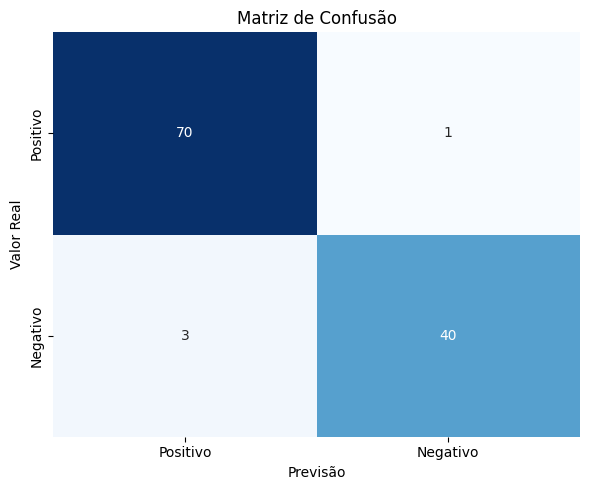

In [36]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Normalizando os dados
norm=Nomalizer()
norm.fit(X_train,y_train)
norm_Trx,norm_Try=norm.normalize(X_train,y_train)
norm_Tsx,norm_Tsy=norm.normalize(X_test,y_test)


# Treinando um modelo
model = NaiveBayesGaussianoClassifier()
model.fit(norm_Trx,y_train)

# Fazendo previsões
y_pred = model.predict(norm_Tsx)

# Contagem para de TP,FN,FP,TN para calcular metricas e matriz de confusão
TP = 0  # Verdadeiro Positivo
FN = 0  # Falso Negativo
FP = 0  # Falso Positivo
TN = 0  # Verdadeiro Negativo


indices = list(range(len(y_pred)))
for i in indices:
    if y_test['y'][i] == 1 and y_pred[i] == 1:
        TP += 1
    elif y_test['y'][i] == 0 and y_pred[i] == 0:
        TN += 1
    elif y_test['y'][i] == 0 and y_pred[i] == 1:
        FP += 1
    elif y_test['y'][i] == 1 and y_pred[i] == 0:
        FN += 1

matriz_confusao = np.array([[TP, FN],
                            [FP, TN]])
print("/////////////////////////////////////////////////")

# Calculo da acuracia
acuracia = (TP + TN) / len(norm_Tsy)
print("acuracia do modelo: ",acuracia)


# Calculo da revocação
revocacao = TP / (TP + FN)
print("revocação do modelo: ",revocacao)

# Calculando a precisão
precisao = TP / (TP + FP) 
print("precisao do modelo: ",precisao)

# Calculando f1-score
f1_score = 2 * (precisao * revocacao) / (precisao + revocacao)
print("f1-score do modelo: ",f1_score)

# Criar o gráfico
plt.figure(figsize=(6, 5))
ax = sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", cbar=False)

# Configurações do gráfico
ax.set_title("Matriz de Confusão")
ax.set_xlabel("Previsão")
ax.set_ylabel("Valor Real")

# Adicionando rótulos aos eixos
ax.xaxis.set_ticklabels(["Positivo", "Negativo"])
ax.yaxis.set_ticklabels(["Positivo", "Negativo"])

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [37]:
# Configurando o KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Para armazenar métricas de cada fold
mse_scores = []
acuracias =[]
revocacoes=[]
precisoes=[]
f1_scores=[]

# Loop pelos folds
for train_index, test_index in kf.split(x):
    # Dividindo os dados em treino e teste
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Normalizando os dados
    norm=Nomalizer()
    norm.fit(X_train,y_train)
    norm_Trx,norm_Try=norm.normalize(X_train,y_train)
    norm_Tsx,norm_Tsy=norm.normalize(X_test,y_test)


    # Treinando um modelo
    model = NaiveBayesGaussianoClassifier()
    model.fit(norm_Trx,y_train)

    # Fazendo previsões
    y_pred = model.predict(norm_Tsx)

    # Contagem para de TP,FN,FP,TN para calcular metricas e matriz de confusão
    TP = 0  # Verdadeiro Positivo
    FN = 0  # Falso Negativo
    FP = 0  # Falso Positivo
    TN = 0  # Verdadeiro Negativo

    indices = list(range(len(y_pred)))
    for i in indices:
        if y_test['y'][i] == 1 and y_pred[i] == 1:
            TP += 1
        elif y_test['y'][i] == 0 and y_pred[i] == 0:
            TN += 1
        elif y_test['y'][i] == 0 and y_pred[i] == 1:
            FP += 1
        elif y_test['y'][i] == 1 and y_pred[i] == 0:
            FN += 1

    matriz_confusao = np.array([[TP, FN],
                                [FP, TN]])
    print("/////////////////////////////////////////////////")

    # Calculo da acuracia
    acuracia = (TP + TN) / len(norm_Tsy)
    print("acuracia do modelo: ",acuracia)
    acuracias.append(acuracia)

    # Calculo da revocação
    revocacao = TP / (TP + FN)
    revocacoes.append(revocacao)
    print("revocação do modelo: ",revocacao)

    # Calculando a precisão
    precisao = TP / (TP + FP) 
    precisoes.append(precisao)
    print("precisao do modelo: ",precisao)

    # Calculando f1-score
    f1_score = 2 * (precisao * revocacao) / (precisao + revocacao)
    f1_scores.append(f1_score)
    print("f1-score do modelo: ",f1_score)

/////////////////////////////////////////////////
acuracia do modelo:  0.9649122807017544
revocação do modelo:  0.975
precisao do modelo:  0.975
f1-score do modelo:  0.975
/////////////////////////////////////////////////
acuracia do modelo:  0.9649122807017544
revocação do modelo:  1.0
precisao do modelo:  0.9393939393939394
f1-score do modelo:  0.96875
/////////////////////////////////////////////////
acuracia do modelo:  0.8771929824561403
revocação do modelo:  0.8918918918918919
precisao do modelo:  0.9166666666666666
f1-score do modelo:  0.9041095890410958
/////////////////////////////////////////////////
acuracia do modelo:  0.9649122807017544
revocação do modelo:  0.975
precisao do modelo:  0.975
f1-score do modelo:  0.975
/////////////////////////////////////////////////
acuracia do modelo:  0.9298245614035088
revocação do modelo:  0.9487179487179487
precisao do modelo:  0.9487179487179487
f1-score do modelo:  0.9487179487179487
/////////////////////////////////////////////////

In [38]:
# Exibindo o resultado
print("/////////////////////////////////////////////////")
print("Metricas Acuracia:")
print("Acuracia médio:", np.mean(acuracias))
print("Desvio padrão Acuracia:", np.std(acuracias))
#print("Acuracia em cada fold:", acuracias)
print(" ")

print("Metricas Revocação:")
print("Revocação médio:", np.mean(revocacoes))
print("Desvio padrão Revocação:", np.std(revocacoes))
#print("Revocações em cada fold:", revocacoes)
print(" ")

print("Metricas Precisão:")
print("Precisão médio:", np.mean(precisoes))
print("Desvio padrão Precisão:", np.std(precisoes))
#print("Precisões em cada fold:", precisoes)
print(" ")

print("Metricas F1-score:")
print("F1-score médio:", np.mean(f1_scores))
print("Desvio padrão F1-score:", np.std(f1_scores))
#print("F1-scores em cada fold:", f1_scores)
print("/////////////////////////////////////////////////")

/////////////////////////////////////////////////
Metricas Acuracia:
Acuracia médio: 0.9313909774436089
Desvio padrão Acuracia: 0.033910212057259845
 
Metricas Revocação:
Revocação médio: 0.9515722453222454
Desvio padrão Revocação: 0.03959664059224107
 
Metricas Precisão:
Precisão médio: 0.9413150910494364
Desvio padrão Precisão: 0.025471197614335334
 
Metricas F1-score:
F1-score médio: 0.9458767856787155
Desvio padrão F1-score: 0.024640950800726227
/////////////////////////////////////////////////


# Experimento do modelo KNN

In [ ]:
from sklearn.model_selection import KFold
import seaborn as sns

In [ ]:
x=breast.iloc[:, 0:30]  
y=breast[['y']]

/////////////////////////////////////////////////
acuracia do modelo:  0.9649122807017544
revocação do modelo:  0.971830985915493
precisao do modelo:  0.971830985915493
f1-score do modelo:  0.971830985915493


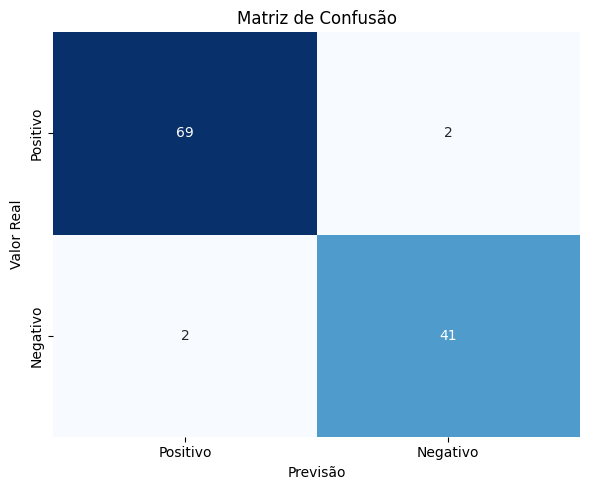

In [39]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Normalizando os dados
norm=Nomalizer()
norm.fit(X_train,y_train)
norm_Trx,norm_Try=norm.normalize(X_train,y_train)
norm_Tsx,norm_Tsy=norm.normalize(X_test,y_test)


# Treinando um modelo
model = KNNClassifier()
model.fit(norm_Trx,y_train)

# Fazendo previsões
y_pred = model.predict(norm_Tsx,3)

# Contagem para de TP,FN,FP,TN para calcular metricas e matriz de confusão
TP = 0  # Verdadeiro Positivo
FN = 0  # Falso Negativo
FP = 0  # Falso Positivo
TN = 0  # Verdadeiro Negativo


indices = list(range(len(y_pred)))
for i in indices:
    if y_test['y'][i] == 1 and y_pred[i] == 1:
        TP += 1
    elif y_test['y'][i] == 0 and y_pred[i] == 0:
        TN += 1
    elif y_test['y'][i] == 0 and y_pred[i] == 1:
        FP += 1
    elif y_test['y'][i] == 1 and y_pred[i] == 0:
        FN += 1

matriz_confusao = np.array([[TP, FN],
                            [FP, TN]])
print("/////////////////////////////////////////////////")

# Calculo da acuracia
acuracia = (TP + TN) / len(norm_Tsy)
print("acuracia do modelo: ",acuracia)


# Calculo da revocação
revocacao = TP / (TP + FN)
print("revocação do modelo: ",revocacao)

# Calculando a precisão
precisao = TP / (TP + FP) 
print("precisao do modelo: ",precisao)

# Calculando f1-score
f1_score = 2 * (precisao * revocacao) / (precisao + revocacao)
print("f1-score do modelo: ",f1_score)

# Criar o gráfico
plt.figure(figsize=(6, 5))
ax = sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", cbar=False)

# Configurações do gráfico
ax.set_title("Matriz de Confusão")
ax.set_xlabel("Previsão")
ax.set_ylabel("Valor Real")

# Adicionando rótulos aos eixos
ax.xaxis.set_ticklabels(["Positivo", "Negativo"])
ax.yaxis.set_ticklabels(["Positivo", "Negativo"])

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [40]:
# Configurando o KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Para armazenar métricas de cada fold
mse_scores = []
acuracias =[]
revocacoes=[]
precisoes=[]
f1_scores=[]

# Loop pelos folds
for train_index, test_index in kf.split(x):
    # Dividindo os dados em treino e teste
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Normalizando os dados
    norm=Nomalizer()
    norm.fit(X_train,y_train)
    norm_Trx,norm_Try=norm.normalize(X_train,y_train)
    norm_Tsx,norm_Tsy=norm.normalize(X_test,y_test)


    # Treinando um modelo
    model = KNNClassifier()
    model.fit(norm_Trx,y_train)

    # Fazendo previsões
    y_pred = model.predict(norm_Tsx,3)

    # Contagem para de TP,FN,FP,TN para calcular metricas e matriz de confusão
    TP = 0  # Verdadeiro Positivo
    FN = 0  # Falso Negativo
    FP = 0  # Falso Positivo
    TN = 0  # Verdadeiro Negativo

    indices = list(range(len(y_pred)))
    for i in indices:
        if y_test['y'][i] == 1 and y_pred[i] == 1:
            TP += 1
        elif y_test['y'][i] == 0 and y_pred[i] == 0:
            TN += 1
        elif y_test['y'][i] == 0 and y_pred[i] == 1:
            FP += 1
        elif y_test['y'][i] == 1 and y_pred[i] == 0:
            FN += 1

    matriz_confusao = np.array([[TP, FN],
                                [FP, TN]])
    print("/////////////////////////////////////////////////")

    # Calculo da acuracia
    acuracia = (TP + TN) / len(norm_Tsy)
    print("acuracia do modelo: ",acuracia)
    acuracias.append(acuracia)

    # Calculo da revocação
    revocacao = TP / (TP + FN)
    revocacoes.append(revocacao)
    print("revocação do modelo: ",revocacao)

    # Calculando a precisão
    precisao = TP / (TP + FP) 
    precisoes.append(precisao)
    print("precisao do modelo: ",precisao)

    # Calculando f1-score
    f1_score = 2 * (precisao * revocacao) / (precisao + revocacao)
    f1_scores.append(f1_score)
    print("f1-score do modelo: ",f1_score)

/////////////////////////////////////////////////
acuracia do modelo:  0.9473684210526315
revocação do modelo:  0.95
precisao do modelo:  0.9743589743589743
f1-score do modelo:  0.9620253164556962
/////////////////////////////////////////////////
acuracia do modelo:  0.9824561403508771
revocação do modelo:  1.0
precisao do modelo:  0.96875
f1-score do modelo:  0.9841269841269841
/////////////////////////////////////////////////
acuracia do modelo:  0.9824561403508771
revocação do modelo:  1.0
precisao do modelo:  0.9736842105263158
f1-score do modelo:  0.9866666666666666
/////////////////////////////////////////////////
acuracia do modelo:  0.9649122807017544
revocação do modelo:  0.95
precisao do modelo:  1.0
f1-score do modelo:  0.9743589743589743
/////////////////////////////////////////////////
acuracia do modelo:  0.9824561403508771
revocação do modelo:  1.0
precisao do modelo:  0.975
f1-score do modelo:  0.9873417721518987
/////////////////////////////////////////////////
acuraci

In [41]:
# Exibindo o resultado
print("/////////////////////////////////////////////////")
print("Metricas Acuracia:")
print("Acuracia médio:", np.mean(acuracias))
print("Desvio padrão Acuracia:", np.std(acuracias))
#print("Acuracia em cada fold:", acuracias)
print(" ")

print("Metricas Revocação:")
print("Revocação médio:", np.mean(revocacoes))
print("Desvio padrão Revocação:", np.std(revocacoes))
#print("Revocações em cada fold:", revocacoes)
print(" ")

print("Metricas Precisão:")
print("Precisão médio:", np.mean(precisoes))
print("Desvio padrão Precisão:", np.std(precisoes))
#print("Precisões em cada fold:", precisoes)
print(" ")

print("Metricas F1-score:")
print("F1-score médio:", np.mean(f1_scores))
print("Desvio padrão F1-score:", np.std(f1_scores))
#print("F1-scores em cada fold:", f1_scores)
print("/////////////////////////////////////////////////")

/////////////////////////////////////////////////
Metricas Acuracia:
Acuracia médio: 0.968295739348371
Desvio padrão Acuracia: 0.019153265258251697
 
Metricas Revocação:
Revocação médio: 0.9875
Desvio padrão Revocação: 0.020155644370746392
 
Metricas Precisão:
Precisão médio: 0.964790867986377
Desvio padrão Precisão: 0.028397741590492378
 
Metricas F1-score:
F1-score médio: 0.9755676567659008
Desvio padrão F1-score: 0.013906153765979925
/////////////////////////////////////////////////
